# Project: Facial emotion recognition
## MTH767P - Group 4

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from pathlib import Path
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from utils import *

## Data loading and pre-processing 

#### Read data

In [3]:
# define dictionary for emotions
emotion_dict = {0: 'Angry', 
                1: 'Disgust', 
                2: 'Fear',
                3: 'Happy', 
                4: 'Sad',
                5: 'Surprise',
                6: 'Neutral'}

In [5]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
dataset_train = EmotionsDataset(root='./dataset', fname='icml_face_data_train.csv', transform=transform)
dataset_validation = EmotionsDataset(root='./dataset', fname='icml_face_data_validation.csv', transform=transform)
dataset_test = EmotionsDataset(root='./dataset', fname='icml_face_data_test.csv', transform=transform)

Loading dataset...	Done
Loading dataset...	Done
Loading dataset...	Done


#### Visualize data


In [6]:
# generate sample of images
#fig, ax = plt.subplots(5, len(emotion_dict), figsize=(8, 4.5))

#for i, em in emotion_dict.items():
    #emotion = dataset.data[dataset.targets==i][:5]
    # set title
    #ax[0, i].set_title(em)
    #for j in range(emotion.shape[0]):      
        #im = emotion[j]
        #ax[j, i].imshow(im, cmap='gray')
        #ax[j, i].axis('off')
#plt.tight_layout();
#plt.savefig(output_path/'dataset_sample.png')

#### Split dataset

In [8]:
torch.manual_seed(0)
trainloader = DataLoader(dataset_train, batch_size = batch_size,shuffle=True)
valloader = DataLoader(dataset_validation, batch_size = batch_size,shuffle=True)
testloader = DataLoader(dataset_test, batch_size = batch_size)

---
## Convolutional neural network setup 
### Network architecture

In [15]:
class Face_Emotion_CNN(nn.Module):
    def __init__(self):
        super(Face_Emotion_CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5,padding=3)
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4,padding=2)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,padding=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128,kernel_size=5,padding=3)
        self.cnn5 = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=4,padding=2)

        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(3,stride=2)
        self.cnn1_bn = nn.BatchNorm2d(32)
        self.cnn2_bn = nn.BatchNorm2d(32)
        self.cnn3_bn = nn.BatchNorm2d(64)
        self.cnn4_bn = nn.BatchNorm2d(128)
        self.cnn5_bn = nn.BatchNorm2d(128)
       

        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2 = nn.Linear(1024, 7)
        self.dropout = nn.Dropout(0.3)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.pool(self.cnn1_bn(self.cnn1(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn2_bn(self.cnn2(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn3_bn(self.cnn3(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn4_bn(self.cnn4(x))))
        #print(x.shape)
        x = self.relu((self.cnn5_bn(self.cnn5(x))))
        #print(x.shape)

        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0],128*4*4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(self.dropout(x)))
        x = self.log_softmax(x)
        return x
    
torch.manual_seed(0)
model = Face_Emotion_CNN()

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from collections import Counter

class_count = {key:Counter(dataset_train.targets)[key] for key in sorted(Counter(dataset_train.targets))}.values()
weight = torch.tensor(list(class_count)) / sum(class_count)
weight = 1-weight
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [17]:
no_epochs = 20
training_loss = []
val_loss = []
val_acc = []
train_acc = []

for epoch in range(no_epochs): 
    scheduler.step()
    running_loss = 0.0
    running_loss_val = 0
    running_loss_train = 0
    correct_val = 0
    total_val = 0
    total_train = 0 
    correct_train = 0
    #print(f"Epoch {epoch+1}")
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

    with torch.no_grad():
        for traindata in trainloader:
            trainimages, trainlabels = traindata
            trainoutputs = model(trainimages)
            loss_train = criterion(trainoutputs, trainlabels)
            running_loss_train += loss_train.item()
            train_, trainpredicted = torch.max(trainoutputs.data, 1)
            total_train += trainlabels.size(0)
            correct_train += (trainpredicted == trainlabels).sum().item()
            
    with torch.no_grad():
        for valdata in valloader:
            valimages, vallabels = valdata
            valoutputs = model(valimages)
            loss_val = criterion(valoutputs, vallabels)
            running_loss_val += loss_val.item()
            val_, valpredicted = torch.max(valoutputs.data, 1)
            total_val += vallabels.size(0)
            correct_val += (valpredicted == vallabels).sum().item()
    
    print(correct_val/total_val)
    training_loss.append(running_loss)
    val_loss.append(running_loss_val)
    val_acc.append(correct_val/total_val)
    train_acc.append(correct_train/total_train)

print('Finished Training')



0.4536082474226804
0.5227082752855948
0.5480635274449708
0.5603232098077459
0.5926441905823349
0.6010030649205907
0.5937587071607691
0.6021175814990248
0.6023962106436334
0.6101978266926721
0.6065756478127612
0.604346614655893
0.6082474226804123
0.6082474226804123
0.6093619392588465
0.60490387294511
0.6093619392588465
0.6107550849818891
0.6104764558372806
0.6065756478127612
Finished Training


In [18]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 61.46558930064085 %


In [19]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Angry is 54.4 %
Accuracy for class: Disgust is 38.2 %
Accuracy for class: Fear  is 41.5 %
Accuracy for class: Happy is 82.7 %
Accuracy for class: Sad   is 48.8 %
Accuracy for class: Surprise is 72.4 %
Accuracy for class: Neutral is 60.9 %


(0.0, 1.0)

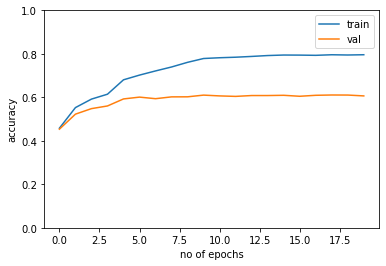

In [20]:
#plt.plot(training_loss)
plt.ylabel("accuracy")
plt.xlabel("no of epochs")
plt.plot(train_acc,label="train")
plt.plot(val_acc,label="val")
plt.legend(["train","val"])
plt.ylim((0,1))

<AxesSubplot:>

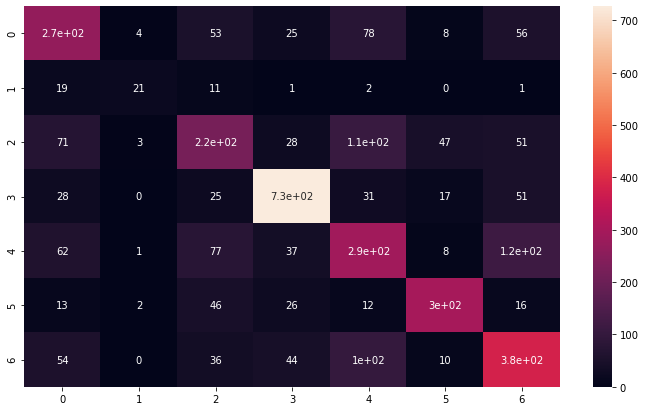

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

In [22]:
cf_matrix

array([[267,   4,  53,  25,  78,   8,  56],
       [ 19,  21,  11,   1,   2,   0,   1],
       [ 71,   3, 219,  28, 109,  47,  51],
       [ 28,   0,  25, 727,  31,  17,  51],
       [ 62,   1,  77,  37, 290,   8, 119],
       [ 13,   2,  46,  26,  12, 301,  16],
       [ 54,   0,  36,  44, 101,  10, 381]], dtype=int64)